In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
%matplotlib inline
import datetime
import seaborn as sns
import xlrd
import cv2
import os
import csv
import re
import pandas as pd
import array as arr
import numpy as np
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
from datetime import datetime
from dateutil import tz
from datetime import timedelta  
import openpyxl
import math

%matplotlib inline


def markProcedureTime(starttime,procedure_start,procedure_end):
    starttime = pd.to_datetime(starttime)
    if(starttime >= procedure_start and starttime <= procedure_end):
        return 1
    
def addOffset(x):
    try:
        z = pd.to_datetime(x)
        return str(z)
    except:
        pass


In [2]:
ds = pd.read_csv('prepped_data_30sec.csv')
len(ds.uhid.unique())

8

In [3]:
data = ds.copy()
listUhid = data.uhid.unique()
manipulationsList = ['Diaper_change','Patting','Feeding']
path = os.getcwd()


In [4]:
uhidlessthan32 = ['191001977','RSHI.0000021833','RSHI.0000023451']
uhidlessthan32to38 = ['200100035','200101135','RSHI.0000024482']

In [7]:
for manipulation in manipulationsList:
    manipulationsListNewlessthan32 = []
    manipulationsListNewlessthan32to38 = []

    manipulationsListNew = []
    
    for uhid in listUhid:

        print(uhid,manipulation)
        dataUhid = data[(data.uhid == uhid) & (data.label == manipulation)]
        print(len(dataUhid))
        titleList = dataUhid.title.unique()
        initialListHR = []
        initialListRR = []
        initialListSpo2 = []
        for i in titleList:
            try:
                dataUhidFilter = dataUhid[dataUhid.title == i]

                dataUhidFilter.sort_values('starttime',inplace=True)

                dataUhidFilter['spo2'].fillna(0,inplace=True)
                dataUhidFilter['heartrate'].fillna(0,inplace=True)

                end_video = pd.to_datetime(dataUhidFilter.procedure_end.iloc[0]) + timedelta(seconds=300)
                start_video = pd.to_datetime(dataUhidFilter.procedure_start.iloc[0]) -timedelta(seconds=300)
                end = pd.to_datetime(dataUhidFilter.procedure_end.iloc[0])

                if(len(dataUhidFilter) > 0):
                    pre = dataUhidFilter[((pd.to_datetime(dataUhidFilter['starttime'])>=start_video)) & (pd.to_datetime(dataUhidFilter['starttime'])<=pd.to_datetime(dataUhidFilter.procedure_start.iloc[0]))]
                    during = dataUhidFilter[(pd.to_datetime(dataUhidFilter['starttime'])>=pd.to_datetime(dataUhidFilter.procedure_start.iloc[0])) & (pd.to_datetime(dataUhidFilter['starttime'])<=pd.to_datetime(dataUhidFilter.procedure_end.iloc[0]))]
                    
                    dataUhidFilter = dataUhidFilter[(pd.to_datetime(dataUhidFilter['starttime'])<=end_video) & (pd.to_datetime(dataUhidFilter['starttime'])>=start_video)]

                    min_hr_pre = dataUhidFilter['heartrate'].min()
                    max_hr_pre = dataUhidFilter['heartrate'].max()
                    min_spo2_pre = dataUhidFilter['spo2'].min()
                    max_spo2_pre = dataUhidFilter['spo2'].max()
                    min_rr_pre = dataUhidFilter['ecg_resprate'].min()
                    max_rr_pre = dataUhidFilter['ecg_resprate'].max()
                    dataUhidFilter['hr_scaled'] = (dataUhidFilter['heartrate']-min_hr_pre)/(max_hr_pre - min_hr_pre)
                    dataUhidFilter['spo2_scaled'] = (dataUhidFilter['spo2']-min_spo2_pre)/(max_spo2_pre - min_spo2_pre)
                    dataUhidFilter['rr_scaled'] = (dataUhidFilter['ecg_resprate']-min_rr_pre)/(max_rr_pre - min_rr_pre)


                    dataUhidFilter['procedure_time'] = 0

                    procedure_start = pd.to_datetime(dataUhidFilter.procedure_start.unique()[0]) - timedelta(seconds=60) 
                    procedure_end = pd.to_datetime(dataUhidFilter.procedure_end.unique()[0]) + timedelta(seconds=60) 



                    dataUhidFilter['procedure_time'] = dataUhidFilter.apply(lambda x: markProcedureTime(x['starttime'],procedure_start,procedure_end), axis=1)
                    dataUhidFilter['ref_hour_x_offset'] = dataUhidFilter['starttime'].apply(addOffset)
                    x = dataUhidFilter['ref_hour_x_offset']
                    folderName = path + '/' + str(uhid)

                    if not os.path.exists(folderName):
                        os.makedirs(folderName)
                        print("making directory",folderName)  
                    newFolderName = folderName + '/' + manipulation + 'physiological'

                    if not os.path.exists(newFolderName):
                        os.makedirs(newFolderName)
                        print("making directory",newFolderName)

                    dataUhidFilter['hr_scaled'] = dataUhidFilter['hr_scaled'].fillna(method='ffill',limit=5)
                    if(len(dataUhidFilter.hr_scaled) >= 10):
                        initialListHR.append(dataUhidFilter.hr_scaled)
                    if(len(dataUhidFilter.rr_scaled) >= 2):
                        initialListRR.append(dataUhidFilter.rr_scaled)
                    if(len(dataUhidFilter.spo2_scaled) >= 2):
                        initialListSpo2.append(dataUhidFilter.spo2_scaled)

            except Exception as e:
                    print(e,'--error----')

        try:
            print('**********Entering***************')

            if(len(initialListHR) > 0):

                finalLitsHR = [(np.nansum(e)/len(e)) for e in zip(*initialListHR)]

                if(uhid in uhidlessthan32):
                    manipulationsListNewlessthan32.append(finalLitsHR)
                elif(uhid in uhidlessthan32to38):
                    manipulationsListNewlessthan32to38.append(finalLitsHR)

                manipulationsListNew.append(finalLitsHR)
                initialListHR = []
                initialListRR = []
                initialListSpo2 = []


        except Exception as e:
            print(e,'*******error*******')
            
    if(manipulation == 'Patting'):
        pattingmanipulationsListNewlessthan32 = manipulationsListNewlessthan32
        pattingmanipulationsListNewlessthan32to38 = manipulationsListNewlessthan32to38
                
    elif(manipulation == 'Feeding'):
        feedingmanipulationsListNewlessthan32 = manipulationsListNewlessthan32
        feedingmanipulationsListNewlessthan32to38 = manipulationsListNewlessthan32to38
    
    elif(manipulation == 'Diaper_change'):
        changemanipulationsListNewlessthan32 = manipulationsListNewlessthan32
        changemanipulationsListNewlessthan32to38 = manipulationsListNewlessthan32to38
       


191001977 Diaper_change
1128


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
200100035 Diaper_change
733


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
200100263 Diaper_change
27
**********Entering***************
200100147 Diaper_change
60
**********Entering***************
200101135 Diaper_change
60
**********Entering***************
RSHI.0000021833 Diaper_change
0
**********Entering***************
RSHI.0000023451 Diaper_change
0
**********Entering***************
RSHI.0000024482 Diaper_change
365


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
191001977 Patting
1411


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
200100035 Patting
971


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
200100263 Patting
60
**********Entering***************
200100147 Patting
239


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
200101135 Patting
119


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
RSHI.0000021833 Patting
168


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
RSHI.0000023451 Patting
0
**********Entering***************
RSHI.0000024482 Patting
0
**********Entering***************
191001977 Feeding
2797


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
200100035 Feeding
1159


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
200100263 Feeding
61
**********Entering***************
200100147 Feeding
239


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
200101135 Feeding
60
**********Entering***************
RSHI.0000021833 Feeding
304


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
RSHI.0000023451 Feeding
182


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************
RSHI.0000024482 Feeding
592


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a c

**********Entering***************


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


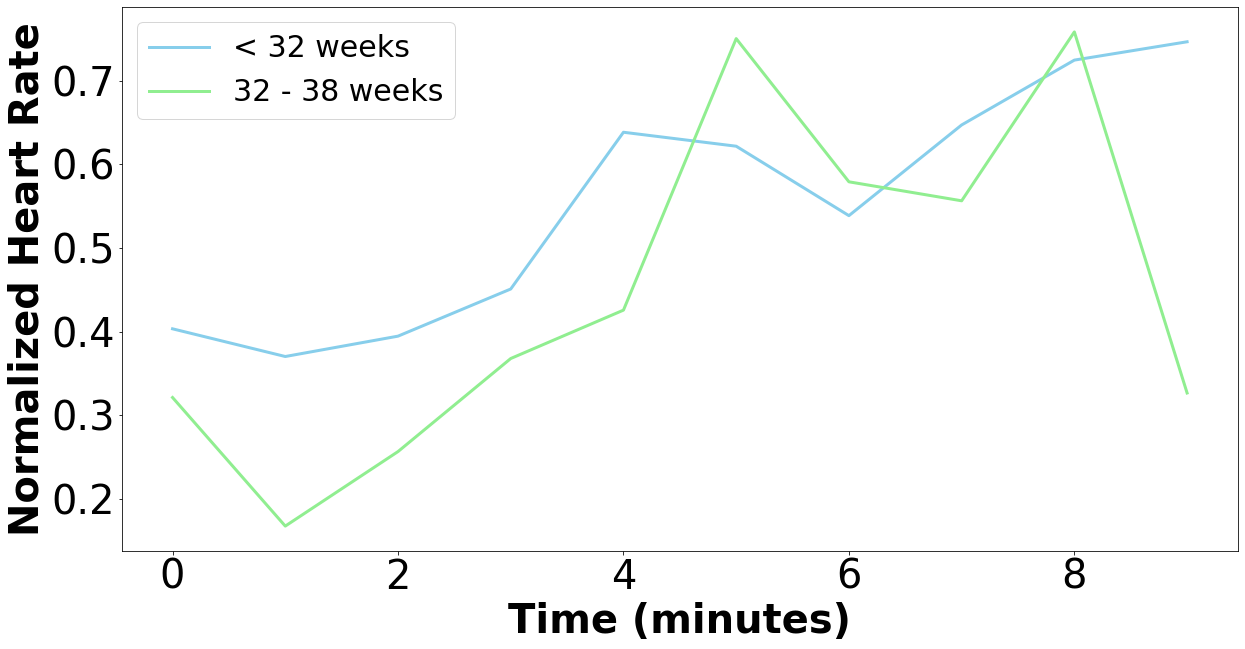

In [8]:
import matplotlib.pyplot as plt2
plt2.rcParams["figure.figsize"] = (20,10)
finalList = []

list1 = [(np.nansum(e)/len(e)) for e in zip(*pattingmanipulationsListNewlessthan32)]
finalList.append(list1)
list2 = [(np.nansum(e)/len(e)) for e in zip(*pattingmanipulationsListNewlessthan32to38)]
finalList.append(list2)

colorList = ['skyblue','lightgreen']
labelList = ['< 32 weeks','32 - 38 weeks']
index = -1
if(len(finalList) > 0):
    for i in finalList:
        index = index + 1
        plt2.plot(i, color=colorList[index],linewidth=3,label=labelList[index])
        plt2.xticks(fontsize=40)
        plt2.yticks(fontsize=40)
        plt2.legend(['< 32 weeks','32 - 38 weeks'],fontsize=30)
        plt2.xlabel('Time (minutes)', fontsize=40,fontweight = 'bold')
        plt2.ylabel('Normalized Heart Rate', fontsize=40,fontweight = 'bold')

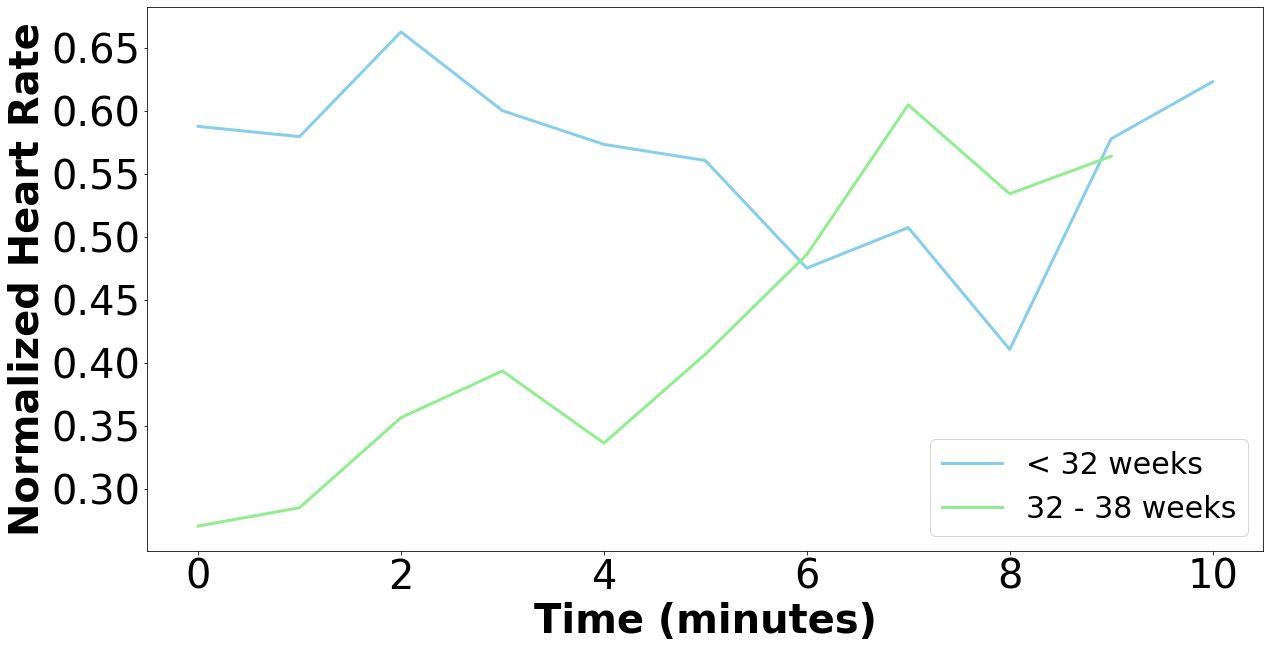

In [9]:
import matplotlib.pyplot as plt2
plt2.rcParams["figure.figsize"] = (20,10)
finalList = []

list1 = [(np.nansum(e)/len(e)) for e in zip(*feedingmanipulationsListNewlessthan32)]
finalList.append(list1)
list2 = [(np.nansum(e)/len(e)) for e in zip(*feedingmanipulationsListNewlessthan32to38)]
finalList.append(list2)

colorList = ['skyblue','lightgreen']
labelList = ['< 32 weeks','32 - 38 weeks']
index = -1
if(len(finalList) > 0):
    for i in finalList:
        index = index + 1
        plt2.plot(i, color=colorList[index],linewidth=3,label=labelList[index])
        plt2.xticks(fontsize=40)
        plt2.yticks(fontsize=40)
        plt2.legend(['< 32 weeks','32 - 38 weeks'],fontsize=30)
        plt2.xlabel('Time (minutes)', fontsize=40,fontweight = 'bold')
        plt2.ylabel('Normalized Heart Rate', fontsize=40,fontweight = 'bold')

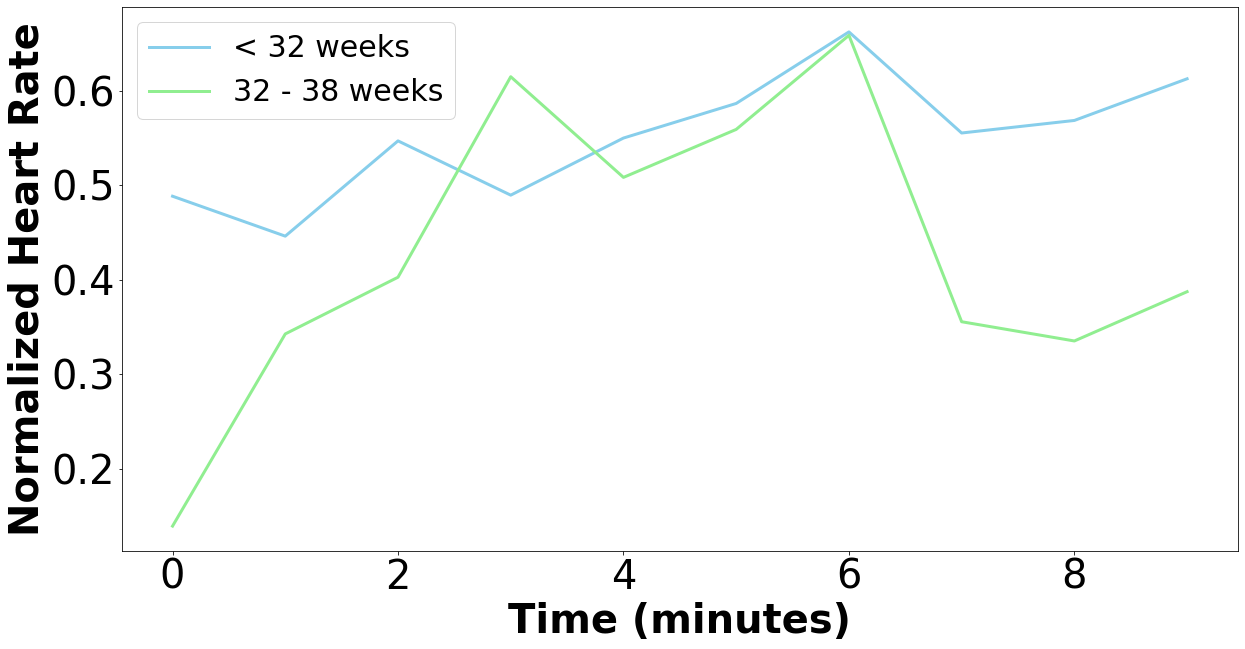

In [10]:
import matplotlib.pyplot as plt2
plt2.rcParams["figure.figsize"] = (20,10)
finalList = []

list1 = [(np.nansum(e)/len(e)) for e in zip(*changemanipulationsListNewlessthan32)]
finalList.append(list1)
list2 = [(np.nansum(e)/len(e)) for e in zip(*changemanipulationsListNewlessthan32to38)]
finalList.append(list2)

colorList = ['skyblue','lightgreen']
labelList = ['< 32 weeks','32 - 38 weeks']
index = -1
if(len(finalList) > 0):
    for i in finalList:
        index = index + 1
        plt2.plot(i, color=colorList[index],linewidth=3,label=labelList[index])
        plt2.xticks(fontsize=40)
        plt2.yticks(fontsize=40)
        plt2.legend(['< 32 weeks','32 - 38 weeks'],fontsize=30)
        plt2.xlabel('Time (minutes)', fontsize=40,fontweight = 'bold')
        plt2.ylabel('Normalized Heart Rate', fontsize=40,fontweight = 'bold')